# 循環セールスマン問題　オリジナル対応版

## 問題データのロード

In [1]:
# ライブラリのロード

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
# データのロード
# 48件は巡回セールスマン問題のオリジナルデータです

url = 'https://raw.githubusercontent.com/makaishi2/sample-data/master/data/att48.csv'
df = pd.read_csv(url)
display(df.head())
print('size = ', df.values.shape)

,x,y
0,6734,1453
1,2233,10
2,5530,1424
3,401,841
4,3082,1644


size =  (48, 2)


In [3]:
# 対象項目数
# N = 25 は10秒程度で解決
# N = 25

# N=30 は4分弱かかる
N = 30

# これ以上の値での結果は未確認

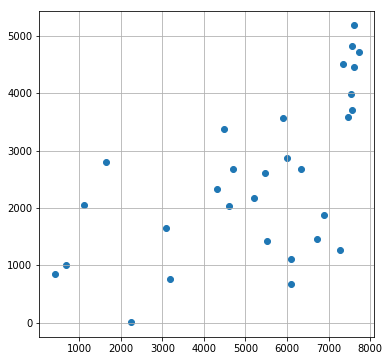

In [4]:
# 絞り込んだデータを使って、初期化と散布図表示

data = df[:N]
data_np = np.array(data)
plt.figure(figsize=(6,6))
plt.scatter(data_np[:,0], data_np[:,1])
plt.grid()
plt.show()

In [5]:
# 距離関数の定義
# 便宜上ユークリッド距離にしています

def distance(i, j):
    return np.sqrt(np.sum((data_np[i,:] - data_np[j,:])** 2))

In [6]:
# コスト配列の定義
c = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        c[i, j] = distance(i, j)

## CPLEXによる問題定義

In [7]:
# CPLEX環境の確認

from docplex.mp.environment import Environment
env = Environment()
env.print_information()

* system is: Linux 64bit
* Python version 3.6.8, located at: /opt/conda/envs/Python36/bin/python
* docplex is present, version is (2, 10, 150)
* CPLEX library is present, version is 12.9.0.1, located at: /opt/conda/envs/Python36/lib/python3.6/site-packages
* pandas is present, version is 0.24.1


### モデルの宣言

In [8]:
# モデルの宣言

from docplex.mp.model import Model
mdl = Model(name="TSP")

In [ ]:
# モデルのパラメータ定義

# スレッド数: 2
mdl.parameters.threads = 2
# 最大時間数: 600秒
mdl.parameters.timelimit = 600

### 決定変数の宣言

In [9]:
# 決定変数の宣言

# x : 移動matrix
# i番目のノードからj番目のノードに移動する時 x_ij = 1
# それ以外の場合 x_ij = 0
x = mdl.integer_var_matrix(N, N)

# u: 順序変数
# 0番目のノードの次に移動するノードがiの場合
# u[i] = 1
# その次に移動するノードがjの場合
# u[j] = 2
# .. のように定義する
u = mdl.integer_var_list(N)

### 制約の定義

In [10]:
# u(順序変数)の制約
# 最初のノードは0番目 : u[0] = 0
# それ以外の順序変数は1以上 N-1以下

mdl.add_constraint(u[0] == 0)
for i in range(1, N):
    mdl.add_constraint(u[i] >= 1)
    mdl.add_constraint(u[i] <= N-1)

In [11]:
# x(移動matrix)の制約
# 自分から自分への移動はないので、u_ii = 0
# それ以外の場合は u_ij は0か1

for i in range(N):
    for j in range(N):
        if i == j:
            mdl.add_constraint(x[i, j] == 0)
        else:
            mdl.add_constraint(x[i, j] >= 0)
            mdl.add_constraint(x[i, j] <= 1)

In [12]:
# x(移動matirx)に関する縦の制約

for i in range(N):
    mdl.add_constraint(mdl.sum(x[i, j] for j in range(N)) == 1)

In [13]:
# x(移動matirx)に関する横の制約

for j in range(N):
    mdl.add_constraint(mdl.sum(x[i, j] for i in range(N)) == 1)

In [14]:
# 部分路制約
# ループが全体で1つであるための条件
# 参考リンク http://satemochi.blog.fc2.com/blog-entry-24.html

for i in range(1, N):
    for j in range(1, N):
        mdl.add_constraint(u[i] - u[j] + N * x[i,j] <= N -1)

### 最適化関数の定義

In [15]:
# 総移動コスト

total_cost = mdl.sum(c[i, j] * x[i, j] for i in range(N) for j in range(N))

In [16]:
# 最適化の定義

mdl.minimize(total_cost)

### 制約設定の確認

In [17]:
# 制約設定の確認

mdl.print_information()

Model: TSP
 - number of variables: 930
   - binary=0, integer=930, continuous=0
 - number of constraints: 2730
   - linear=2730
 - parameters: defaults
 - problem type is: MILP


## 問題を解く

In [18]:
# 問題を解く
# ログ出力をONにして、詳細情報も表示します

mdl.solve(log_output = True)
mdl.report()

CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 2
Tried aggregator 1 time.
MIP Presolve eliminated 1858 rows and 31 columns.
MIP Presolve modified 1624 coefficients.
Reduced MIP has 872 rows, 899 columns, and 4176 nonzeros.
Reduced MIP has 870 binaries, 29 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (3.03 ticks)
Probing time = 0.01 sec. (2.90 ticks)
Tried aggregator 1 time.
Reduced MIP has 872 rows, 899 columns, and 4176 nonzeros.
Reduced MIP has 870 binaries, 29 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (3.18 ticks)
Probing time = 0.01 sec. (2.89 ticks)
Clique table members: 466.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 2 threads.
Root relaxation solution time = 0.00 sec. (1.41 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItC

In [19]:
# 詳細情報の表示

print(mdl.get_solve_details())

status  = integer optimal, tolerance
time    = 228.216 s.
problem = MILP
gap     = 0.00996211%



In [20]:
# 結果の取得

indexes = [u[i].solution_value for i in range(N)]
matrix = [[x[i, j].solution_value for j in range(N)] for i in range(N)]
ar = np.array(matrix)

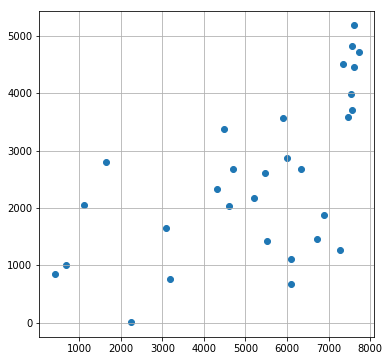

In [21]:
# オリジナル散布図の再表示

plt.figure(figsize=(6,6))
plt.scatter(data_np[:,0], data_np[:,1])
plt.grid()
plt.show()

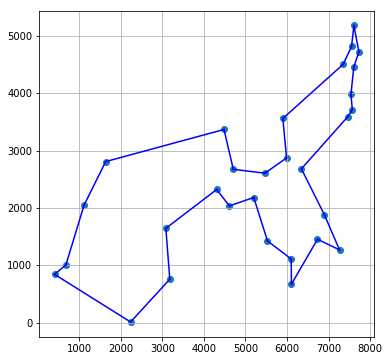

In [22]:
# 結果の散布図上での表示

data_np = np.array(data)
plt.figure(figsize=(6,6))
plt.scatter(data_np[:,0], data_np[:,1])
for i in range(N):
    for j in range(N):
        if ar[i, j] == 1:
            plt.plot(data_np[[i,j],0], data_np[[i,j],1], c='b')
plt.grid()            
plt.show()